# Import libraries

In [1]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
from scipy import ndimage

# Define folder and filename of data

In [7]:
folder = '/Users/c.liebscher/Documents/PycharmProjects/ImageSimulations/2022/AI-STEM_TrainingData/simulationCells/FCC-Cu/test/'

files = [i for i in os.listdir(folder) if i.endswith("_FP12.hdf5")]
images = [os.path.join(folder, i) for i in files]

# Loop through simulated STEM reference images and augment

In [8]:
for image in images:

    # Read simulated STEM image from hdf5 file
    f = h5py.File(image,'r')
    img = f.get('array')
    pixel_size = f.get('sampling') # in Angstrom
    units = f.get('units')
    #f.close()
    
    # Original image size
    Nx, Ny = img.shape
    
    # Specify replication of original simulated image for augmentation
    rep_img = 4
    
    # In case the original simulated STEM image is not square it will adapt the replication to make the image square
    if (Nx-Ny)>0:
        img_ratio = Nx/Ny
        rep_img = rep_img, int(rep_img*img_ratio)
    elif (Ny-Nx)>0:
        img_ratio = Ny/Nx
        rep_img = int(rep_img*img_ratio), rep_img
    else:
        rep_img = rep_img, rep_img
    
    # Replicate image
    imgrep = np.matlib.repmat(img, rep_img[0], rep_img[1])
    Nxrep, Nyrep = imgrep.shape
    
    # If image size is odd, make even in the corresponding direction by removing a one pixel boundary
    if (Nxrep % 2) == 0:
        Nxrep = Nxrep
    else:
        imgrep = imgrep[:Nxrep-1,:]
        
    if (Nyrep % 2) == 0:
        Nyrep = Nyrep
    else:
        imgrep = imgrep[:,:Nyrep-1]
        
    Nxrep, Nyrep = imgrep.shape
        
    # Specify the minimum and maximum rotation angles and the rotation increment
    rotmin = 0
    rotmax = 90
    rotinc = 5
    rotRange = np.arange(rotmin,rotmax+rotinc,rotinc)
    
    # Specify the field of view of the rotated images in Angstrom, so that all images are cropped to that size
    fov = 12 # field of view in Angstrom

    # Prepare output array
    size_crop = int(np.round(fov/(np.round(pixel_size[0]*100)/100)))
    imgrot = np.zeros((size_crop, size_crop, rotRange.size), dtype=float)
    Nxrot, Nyrot, Nzrot = np.shape(imgrot)

    for a0 in range(0, rotRange.size, 1):

        #Rotate images
        imgrot_temp = ndimage.rotate(imgrep, rotRange[a0], reshape=False)

        #Crop image to maintain same field of view of here 1.2x1.2nm**2, if rectangular use smaller dimension
        #if (Nx-Ny) < 0:
        #    crop = Nxrep-Nx, Nyrep-Ny
        #elif (Nx-Ny) > 0:
        #    crop = int(np.round(((Nyrot*pixel_size[0]-fov)/pixel_size[0])/2))
        #else:
        #    crop = int(np.round(((Nxrot*pixel_size[0]-fov)/pixel_size[0])/2)) 
        
        crop = int((Nxrep-Nxrot)/2), int((Nyrep-Nyrot)/2)

        #Crop image
        imgrot[:,:,a0] = imgrot_temp[crop[0]:int(Nxrep-crop[0]),crop[1]:int(Nyrep-crop[1])]
        
    # Save to hdf5 file
    hf = h5py.File(image[:-5] + '_augmented_images.hdf5', 'w')
    group1 = hf.create_group('Image_rotation')
    group1.create_dataset('Rotated_images', data=imgrot)
    group1.create_dataset('Rotation_angles', data=rotRange)
    hf.close()

# Extract test images from saved hdf5 file

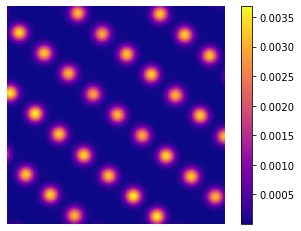

In [11]:
file = h5py.File(images[0][:-5] + '_augmented_images.hdf5','r')

#List groups in hdf5 file
file_groups = file.keys()

#Extract datasets for each group
file_data = file.get('Image_rotation')
img = file_data.get('Rotated_images')

#Plot selected image
n = 10

plt.imshow(img[:,:,n], cmap='plasma')
plt.axis('off')
plt.colorbar()
plt.show()

file.close()